In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.metrics import r2_score

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')


## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_21040\3199085973.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

## 画出数据

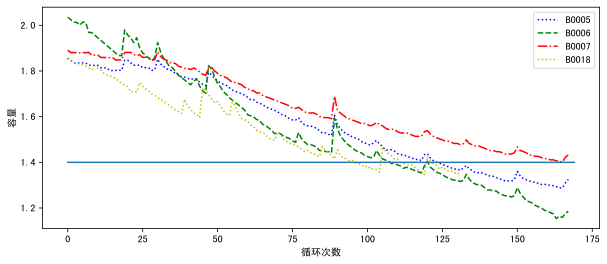

In [3]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(170)], [1.4] * 170)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [Battery['B0005'][1], Battery['B0006'][1], Battery['B0007'][1], Battery['B0018'][1]]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [4]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 构建训练序列数据

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [8]:
train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, 0, window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 2, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

torch.Size([2, 16])
torch.Size([2, 16])
tensor([[2.0353, 2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682,
         1.9572, 1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892],
        [2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783]])
tensor([[2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783],
        [2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
         1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676]])


## 绘制 out 和  tgt_y的对比图

In [9]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 随机种子

In [6]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 搭建模型

In [7]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=128, nhead=16, num_encoder_layers=2, dim_feedforward=512, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状

In [15]:
# 测试模型的输出形状
net = Net(d_model=32).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 16, 1])


## 一个批次的训练函数

In [8]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
        #print(src.device)
        #print(tgt.device)
        
        out = net(x)
        
    
        #print('111out', out.shape) # (50, 153, 1)
        # print('111tgt_y', tgt_y.shape) # (50, 153)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        #print('222out', out[-1, :, :].cpu().data.numpy().shape) # (50, 153, 1)
        #print('222tgt_y', tgt_y.shape) # (50, 153)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [9]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        if (len(re_epoch_list) == 0 or (r2_epoch_list[-1] < r2)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [10]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        
        
        pred_next_point = pred.cpu().data.numpy()[-1]
        
        
        pre_list.append(pred_next_point)
        
        
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 开始训练 num_epochs = 500

### is_train=True 判断函数是(r2_epoch_list[-1] < r2)

In [22]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 2
dim_feedforward = 64

batch_size = 50
lr = 0.001
weight_decay = 0.00001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 min: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.0841204077 , MAE:0.2120 , RMSE:0.2525 , RE:0.3945 , R2:-0.9743
seed: 0, 测试集: B0005, epoch:3    , loss:0.0495023802 , MAE:0.1682 , RMSE:0.2079 , RE:0.3945 , R2:-0.3382
seed: 0, 测试集: B0005, epoch:4    , loss:0.0512132049 , MAE:0.1580 , RMSE:0.1789 , RE:0.3945 , R2:0.0089
seed: 0, 测试集: B0005, epoch:74   , loss:0.0016636726 , MAE:0.0952 , RMSE:0.1086 , RE:0.3578 , R2:0.6352
seed: 0, 测试集: B0005, epoch:81   , loss:0.0013339872 , MAE:0.0445 , RMSE:0.0514 , RE:0.1284 , R2:0.9184
seed: 0, 测试集: B0005, epoch:108  , loss:0.0011795172 , MAE:0.0213 , RMSE:0.0259 , RE:0.0275 , R2:0.9792
seed: 0, 测试集: B0005, epoch:112  , loss:0.0010366001 , MAE:0.0201 , RMSE:0.0253 , RE:0.0459 , R2:0.9802
seed: 0, 测试集: B0005, epoch:127  , loss:0.0010181951 , MAE:0.0189 , RMSE:0.0239 , RE:0.0000 , R2:0.9824
以电池 B0006 为测试数据的 数据

seed: 1, 测试集: B0006, epoch:398  , loss:0.0003066073 , MAE:0.0584 , RMSE:0.0667 , RE:0.1398 , R2:0.9087
seed: 1, 测试集: B0006, epoch:414  , loss:0.0003090089 , MAE:0.0272 , RMSE:0.0358 , RE:0.0108 , R2:0.9737
以电池 B0007 为测试数据的 数据集 开始训练
seed: 1, 测试集: B0007, epoch:1    , loss:0.2427740097 , MAE:0.4615 , RMSE:0.4854 , RE:0.0000 , R2:-9.5206
seed: 1, 测试集: B0007, epoch:2    , loss:0.0469661206 , MAE:0.1282 , RMSE:0.1543 , RE:0.0000 , R2:-0.0633
seed: 1, 测试集: B0007, epoch:5    , loss:0.0267095212 , MAE:0.1262 , RMSE:0.1489 , RE:0.0000 , R2:0.0102
seed: 1, 测试集: B0007, epoch:7    , loss:0.0242232326 , MAE:0.1241 , RMSE:0.1449 , RE:0.0000 , R2:0.0622
seed: 1, 测试集: B0007, epoch:10   , loss:0.0105496347 , MAE:0.1052 , RMSE:0.1210 , RE:0.0000 , R2:0.3465
seed: 1, 测试集: B0007, epoch:11   , loss:0.0081690457 , MAE:0.0790 , RMSE:0.0900 , RE:0.0000 , R2:0.6384
seed: 1, 测试集: B0007, epoch:304  , loss:0.0004556308 , MAE:0.0263 , RMSE:0.0313 , RE:0.0921 , R2:0.9564
seed: 1, 测试集: B0007, epoch:342  , loss:0.0006

seed: 3, 测试集: B0005, epoch:171  , loss:0.0011568967 , MAE:0.1249 , RMSE:0.1463 , RE:0.3945 , R2:0.3378
seed: 3, 测试集: B0005, epoch:182  , loss:0.0010465368 , MAE:0.0877 , RMSE:0.1026 , RE:0.3945 , R2:0.6738
seed: 3, 测试集: B0005, epoch:190  , loss:0.0009062229 , MAE:0.0563 , RMSE:0.0632 , RE:0.3119 , R2:0.8762
seed: 3, 测试集: B0005, epoch:214  , loss:0.0010347764 , MAE:0.0537 , RMSE:0.0603 , RE:0.2569 , R2:0.8876
seed: 3, 测试集: B0005, epoch:218  , loss:0.0009708774 , MAE:0.0410 , RMSE:0.0475 , RE:0.1284 , R2:0.9301
seed: 3, 测试集: B0005, epoch:232  , loss:0.0011075172 , MAE:0.0349 , RMSE:0.0401 , RE:0.1193 , R2:0.9503
seed: 3, 测试集: B0005, epoch:283  , loss:0.0009956631 , MAE:0.0311 , RMSE:0.0378 , RE:0.0734 , R2:0.9557
seed: 3, 测试集: B0005, epoch:328  , loss:0.0007250053 , MAE:0.0289 , RMSE:0.0367 , RE:0.0459 , R2:0.9582
seed: 3, 测试集: B0005, epoch:333  , loss:0.0007078624 , MAE:0.0305 , RMSE:0.0365 , RE:0.0826 , R2:0.9587
seed: 3, 测试集: B0005, epoch:336  , loss:0.0008495796 , MAE:0.0249 , RMSE:0

seed: 4, 测试集: B0007, epoch:262  , loss:0.0010339683 , MAE:0.0282 , RMSE:0.0354 , RE:0.1382 , R2:0.9440
seed: 4, 测试集: B0007, epoch:426  , loss:0.0008989889 , MAE:0.0268 , RMSE:0.0324 , RE:0.1053 , R2:0.9532
seed: 4, 测试集: B0007, epoch:432  , loss:0.0007077174 , MAE:0.0239 , RMSE:0.0290 , RE:0.0658 , R2:0.9625
seed: 4, 测试集: B0007, epoch:497  , loss:0.0007761686 , MAE:0.0222 , RMSE:0.0271 , RE:0.0789 , R2:0.9672
以电池 B0018 为测试数据的 数据集 开始训练
seed: 4, 测试集: B0018, epoch:1    , loss:0.0862980485 , MAE:0.2298 , RMSE:0.2631 , RE:0.4321 , R2:-3.1594
seed: 4, 测试集: B0018, epoch:3    , loss:0.0398400687 , MAE:0.1140 , RMSE:0.1292 , RE:0.4321 , R2:-0.0024
seed: 4, 测试集: B0018, epoch:19   , loss:0.0306200683 , MAE:0.1168 , RMSE:0.1273 , RE:0.4321 , R2:0.0257
seed: 4, 测试集: B0018, epoch:22   , loss:0.0208362322 , MAE:0.1068 , RMSE:0.1215 , RE:0.4321 , R2:0.1128
seed: 4, 测试集: B0018, epoch:28   , loss:0.0115343314 , MAE:0.0892 , RMSE:0.1071 , RE:0.4321 , R2:0.3107
seed: 4, 测试集: B0018, epoch:29   , loss:0.0096

seed: 6, 测试集: B0005, epoch:125  , loss:0.0011084547 , MAE:0.0694 , RMSE:0.0805 , RE:0.3945 , R2:0.7996
seed: 6, 测试集: B0005, epoch:153  , loss:0.0007906174 , MAE:0.0657 , RMSE:0.0753 , RE:0.3670 , R2:0.8242
seed: 6, 测试集: B0005, epoch:203  , loss:0.0007894422 , MAE:0.0311 , RMSE:0.0374 , RE:0.0734 , R2:0.9567
seed: 6, 测试集: B0005, epoch:206  , loss:0.0010134079 , MAE:0.0330 , RMSE:0.0368 , RE:0.1376 , R2:0.9581
seed: 6, 测试集: B0005, epoch:217  , loss:0.0007528352 , MAE:0.0207 , RMSE:0.0247 , RE:0.0459 , R2:0.9812
seed: 6, 测试集: B0005, epoch:223  , loss:0.0009746725 , MAE:0.0194 , RMSE:0.0239 , RE:0.0367 , R2:0.9823
seed: 6, 测试集: B0005, epoch:263  , loss:0.0007224496 , MAE:0.0176 , RMSE:0.0236 , RE:0.0092 , R2:0.9828
以电池 B0006 为测试数据的 数据集 开始训练
seed: 6, 测试集: B0006, epoch:1    , loss:0.2569442689 , MAE:0.6480 , RMSE:0.6850 , RE:0.6344 , R2:-8.6217
seed: 6, 测试集: B0006, epoch:2    , loss:0.0335342176 , MAE:0.2469 , RMSE:0.2813 , RE:0.6344 , R2:-0.6222
seed: 6, 测试集: B0006, epoch:3    , loss:0.0770

seed: 7, 测试集: B0018, epoch:9    , loss:0.0359954610 , MAE:0.1109 , RMSE:0.1227 , RE:0.4321 , R2:0.0957
seed: 7, 测试集: B0018, epoch:12   , loss:0.0182642117 , MAE:0.0978 , RMSE:0.1069 , RE:0.4321 , R2:0.3132
seed: 7, 测试集: B0018, epoch:13   , loss:0.0110234395 , MAE:0.0497 , RMSE:0.0641 , RE:0.2469 , R2:0.7528
seed: 7, 测试集: B0018, epoch:16   , loss:0.0061384384 , MAE:0.0383 , RMSE:0.0535 , RE:0.0370 , R2:0.8281
seed: 7, 测试集: B0018, epoch:17   , loss:0.0053866114 , MAE:0.0457 , RMSE:0.0526 , RE:0.1852 , R2:0.8337
seed: 7, 测试集: B0018, epoch:35   , loss:0.0022432574 , MAE:0.0352 , RMSE:0.0450 , RE:0.0370 , R2:0.8781
seed: 7, 测试集: B0018, epoch:79   , loss:0.0017735789 , MAE:0.0339 , RMSE:0.0385 , RE:0.1111 , R2:0.9109
seed: 7, 测试集: B0018, epoch:88   , loss:0.0011057652 , MAE:0.0326 , RMSE:0.0374 , RE:0.0988 , R2:0.9160
seed: 7, 测试集: B0018, epoch:155  , loss:0.0012857576 , MAE:0.0283 , RMSE:0.0346 , RE:0.0617 , R2:0.9280
---------------------------------
re_s [0.027522935779816515, 0.096774193

seed: 9, 测试集: B0005, epoch:8    , loss:0.0171056595 , MAE:0.1548 , RMSE:0.1743 , RE:0.3945 , R2:0.0590
seed: 9, 测试集: B0005, epoch:9    , loss:0.0164326020 , MAE:0.1499 , RMSE:0.1706 , RE:0.3945 , R2:0.0989
seed: 9, 测试集: B0005, epoch:10   , loss:0.0137662590 , MAE:0.1444 , RMSE:0.1677 , RE:0.3945 , R2:0.1297
seed: 9, 测试集: B0005, epoch:20   , loss:0.0036966742 , MAE:0.0697 , RMSE:0.0775 , RE:0.3945 , R2:0.8142
seed: 9, 测试集: B0005, epoch:22   , loss:0.0037735931 , MAE:0.0402 , RMSE:0.0512 , RE:0.0275 , R2:0.9189
seed: 9, 测试集: B0005, epoch:36   , loss:0.0020277721 , MAE:0.0379 , RMSE:0.0464 , RE:0.0367 , R2:0.9333
seed: 9, 测试集: B0005, epoch:79   , loss:0.0011502971 , MAE:0.0353 , RMSE:0.0412 , RE:0.1009 , R2:0.9476
seed: 9, 测试集: B0005, epoch:87   , loss:0.0012156841 , MAE:0.0292 , RMSE:0.0393 , RE:0.0367 , R2:0.9521
seed: 9, 测试集: B0005, epoch:88   , loss:0.0010009466 , MAE:0.0289 , RMSE:0.0379 , RE:0.0459 , R2:0.9555
seed: 9, 测试集: B0005, epoch:161  , loss:0.0008710888 , MAE:0.0326 , RMSE:0

## 以4个评价指标的和为判断函数 开始训练

In [11]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = re + mae + rmse - r2
            lastSum = re_epoch_list[-1] + mae_epoch_list[-1] + rmse_epoch_list[-1] - r2_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 2
dim_feedforward = 64

batch_size = 50
lr = 0.001
weight_decay = 0.00001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.0841204077 , MAE:0.2120 , RMSE:0.2525 , RE:0.3945 , R2:-0.9743 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:3    , loss:0.0495023802 , MAE:0.1682 , RMSE:0.2079 , RE:0.3945 , R2:-0.3382 , currentSum:1.1087
seed: 0, 测试集: B0005, epoch:4    , loss:0.0512132049 , MAE:0.1580 , RMSE:0.1789 , RE:0.3945 , R2:0.0089 , currentSum:0.7226
seed: 0, 测试集: B0005, epoch:74   , loss:0.0016636726 , MAE:0.0952 , RMSE:0.1086 , RE:0.3578 , R2:0.6352 , currentSum:-0.0736
seed: 0, 测试集: B0005, epoch:81   , loss:0.0013339872 , MAE:0.0445 , RMSE:0.0514 , RE:0.1284 , R2:0.9184 , currentSum:-0.6941
seed: 0, 测试集: B0005, epoch:108  , loss:0.0011795172 , MAE:0.0213 , RMSE:0.0259 , RE:0.0275 , R2:0.9792 , currentSum:-0.9044
seed: 0, 测试集: B0005, epoch:127  , loss:0.0010181951 , MAE:0.0189 , RMSE:0.0239 , RE:0.0000 , R2:0.9824

seed: 1, 测试集: B0006, epoch:3    , loss:0.0382259786 , MAE:0.2231 , RMSE:0.2516 , RE:0.6344 , R2:-0.2983 , currentSum:1.4074
seed: 1, 测试集: B0006, epoch:4    , loss:0.0384641886 , MAE:0.2225 , RMSE:0.2510 , RE:0.6344 , R2:-0.2922 , currentSum:1.4002
seed: 1, 测试集: B0006, epoch:5    , loss:0.0480371043 , MAE:0.1894 , RMSE:0.2207 , RE:0.6344 , R2:0.0011 , currentSum:1.0434
seed: 1, 测试集: B0006, epoch:12   , loss:0.0183874853 , MAE:0.1840 , RMSE:0.2118 , RE:0.6344 , R2:0.0799 , currentSum:0.9504
seed: 1, 测试集: B0006, epoch:14   , loss:0.0118057700 , MAE:0.1733 , RMSE:0.1987 , RE:0.6344 , R2:0.1907 , currentSum:0.8157
seed: 1, 测试集: B0006, epoch:15   , loss:0.0096915979 , MAE:0.1417 , RMSE:0.1640 , RE:0.6344 , R2:0.4482 , currentSum:0.4919
seed: 1, 测试集: B0006, epoch:80   , loss:0.0010806479 , MAE:0.1455 , RMSE:0.1603 , RE:0.6022 , R2:0.4733 , currentSum:0.4345
seed: 1, 测试集: B0006, epoch:167  , loss:0.0006744671 , MAE:0.1498 , RMSE:0.1640 , RE:0.4731 , R2:0.4481 , currentSum:0.3388
seed: 1, 测试集: 

seed: 2, 测试集: B0018, epoch:4    , loss:0.0235385653 , MAE:0.1150 , RMSE:0.1452 , RE:0.4321 , R2:-0.2670 , currentSum:0.9593
seed: 2, 测试集: B0018, epoch:5    , loss:0.0312644988 , MAE:0.1213 , RMSE:0.1335 , RE:0.4321 , R2:-0.0713 , currentSum:0.7582
seed: 2, 测试集: B0018, epoch:6    , loss:0.0294234864 , MAE:0.1173 , RMSE:0.1280 , RE:0.4321 , R2:0.0156 , currentSum:0.6618
seed: 2, 测试集: B0018, epoch:7    , loss:0.0169989970 , MAE:0.1129 , RMSE:0.1230 , RE:0.4321 , R2:0.0916 , currentSum:0.5763
seed: 2, 测试集: B0018, epoch:21   , loss:0.0026495550 , MAE:0.0521 , RMSE:0.0614 , RE:0.3333 , R2:0.7732 , currentSum:-0.3263
seed: 2, 测试集: B0018, epoch:72   , loss:0.0013442471 , MAE:0.0391 , RMSE:0.0444 , RE:0.1852 , R2:0.8816 , currentSum:-0.6130
seed: 2, 测试集: B0018, epoch:78   , loss:0.0012846561 , MAE:0.0370 , RMSE:0.0432 , RE:0.0864 , R2:0.8878 , currentSum:-0.7211
seed: 2, 测试集: B0018, epoch:128  , loss:0.0006668448 , MAE:0.0346 , RMSE:0.0398 , RE:0.0864 , R2:0.9049 , currentSum:-0.7441
seed: 2, 测

seed: 3, 测试集: B0018, epoch:282  , loss:0.0004862312 , MAE:0.0355 , RMSE:0.0455 , RE:0.0123 , R2:0.8757 , currentSum:-0.7824
seed: 3, 测试集: B0018, epoch:303  , loss:0.0004120578 , MAE:0.0330 , RMSE:0.0433 , RE:0.0123 , R2:0.8874 , currentSum:-0.7989
seed: 3, 测试集: B0018, epoch:443  , loss:0.0002214378 , MAE:0.0339 , RMSE:0.0445 , RE:0.0000 , R2:0.8810 , currentSum:-0.8026
---------------------------------
re_s [0.01834862385321101, 0.20430107526881722, 0.0, 0.0]
---------------------------------
re mean: 0.05566242478050706
mae mean: 0.04175780957758457
rmse mean: 0.051220845264403
r2 mean: 0.9005338791736525
---------------------------------
*******************************************************************************************************************
当前的 seed 为 4
以电池 B0005 为测试数据的 数据集 开始训练
seed: 4, 测试集: B0005, epoch:1    , loss:0.0934298858 , MAE:0.2426 , RMSE:0.2925 , RE:0.3945 , R2:-1.6480 , currentSum:0.0000
seed: 4, 测试集: B0005, epoch:3    , loss:0.0473641790 , MAE:0.1781 , RMSE:0

seed: 5, 测试集: B0006, epoch:4    , loss:0.0879490301 , MAE:0.1790 , RMSE:0.2230 , RE:0.6344 , R2:-0.0197 , currentSum:1.0561
seed: 5, 测试集: B0006, epoch:19   , loss:0.0217198059 , MAE:0.1886 , RMSE:0.2155 , RE:0.6344 , R2:0.0480 , currentSum:0.9905
seed: 5, 测试集: B0006, epoch:22   , loss:0.0135003552 , MAE:0.1826 , RMSE:0.2082 , RE:0.6344 , R2:0.1108 , currentSum:0.9145
seed: 5, 测试集: B0006, epoch:29   , loss:0.0055372077 , MAE:0.1705 , RMSE:0.1959 , RE:0.6344 , R2:0.2131 , currentSum:0.7877
seed: 5, 测试集: B0006, epoch:32   , loss:0.0049026012 , MAE:0.1081 , RMSE:0.1198 , RE:0.3871 , R2:0.7055 , currentSum:-0.0904
seed: 5, 测试集: B0006, epoch:33   , loss:0.0055403747 , MAE:0.0764 , RMSE:0.0896 , RE:0.2581 , R2:0.8355 , currentSum:-0.4115
seed: 5, 测试集: B0006, epoch:36   , loss:0.0045572175 , MAE:0.0787 , RMSE:0.0992 , RE:0.1075 , R2:0.7984 , currentSum:-0.5130
seed: 5, 测试集: B0006, epoch:37   , loss:0.0048343050 , MAE:0.0676 , RMSE:0.0816 , RE:0.1183 , R2:0.8636 , currentSum:-0.5961
seed: 5, 测试

seed: 6, 测试集: B0007, epoch:19   , loss:0.0221462380 , MAE:0.1267 , RMSE:0.1441 , RE:0.0000 , R2:0.0734 , currentSum:0.1973
seed: 6, 测试集: B0007, epoch:24   , loss:0.0102834171 , MAE:0.0971 , RMSE:0.1104 , RE:0.0000 , R2:0.4554 , currentSum:-0.2478
seed: 6, 测试集: B0007, epoch:27   , loss:0.0070115365 , MAE:0.0670 , RMSE:0.0900 , RE:0.2237 , R2:0.6383 , currentSum:-0.2576
seed: 6, 测试集: B0007, epoch:28   , loss:0.0061726975 , MAE:0.0779 , RMSE:0.0864 , RE:0.0000 , R2:0.6670 , currentSum:-0.5027
seed: 6, 测试集: B0007, epoch:59   , loss:0.0024307368 , MAE:0.0387 , RMSE:0.0510 , RE:0.1711 , R2:0.8838 , currentSum:-0.6230
seed: 6, 测试集: B0007, epoch:68   , loss:0.0020633920 , MAE:0.0279 , RMSE:0.0320 , RE:0.0461 , R2:0.9541 , currentSum:-0.8482
seed: 6, 测试集: B0007, epoch:136  , loss:0.0012569673 , MAE:0.0297 , RMSE:0.0364 , RE:0.0197 , R2:0.9407 , currentSum:-0.8548
seed: 6, 测试集: B0007, epoch:254  , loss:0.0010569555 , MAE:0.0278 , RMSE:0.0354 , RE:0.0197 , R2:0.9441 , currentSum:-0.8612
seed: 6, 

seed: 8, 测试集: B0005, epoch:1    , loss:0.1142953858 , MAE:0.1622 , RMSE:0.1820 , RE:0.3945 , R2:-0.0258 , currentSum:0.0000
seed: 8, 测试集: B0005, epoch:5    , loss:0.0483756475 , MAE:0.1589 , RMSE:0.1795 , RE:0.3945 , R2:0.0028 , currentSum:0.7301
seed: 8, 测试集: B0005, epoch:16   , loss:0.0305311363 , MAE:0.1565 , RMSE:0.1767 , RE:0.3945 , R2:0.0330 , currentSum:0.6947
seed: 8, 测试集: B0005, epoch:21   , loss:0.0181015916 , MAE:0.1477 , RMSE:0.1699 , RE:0.3945 , R2:0.1066 , currentSum:0.6055
seed: 8, 测试集: B0005, epoch:116  , loss:0.0022016892 , MAE:0.1243 , RMSE:0.1426 , RE:0.3945 , R2:0.3704 , currentSum:0.2911
seed: 8, 测试集: B0005, epoch:125  , loss:0.0014793505 , MAE:0.0801 , RMSE:0.0902 , RE:0.3945 , R2:0.7479 , currentSum:-0.1830
seed: 8, 测试集: B0005, epoch:136  , loss:0.0013363654 , MAE:0.0429 , RMSE:0.0482 , RE:0.2202 , R2:0.9282 , currentSum:-0.6169
seed: 8, 测试集: B0005, epoch:143  , loss:0.0014846070 , MAE:0.0372 , RMSE:0.0459 , RE:0.0550 , R2:0.9349 , currentSum:-0.7968
seed: 8, 测试集

seed: 9, 测试集: B0005, epoch:133  , loss:0.0008718133 , MAE:0.0308 , RMSE:0.0410 , RE:0.0275 , R2:0.9479 , currentSum:-0.8486
seed: 9, 测试集: B0005, epoch:278  , loss:0.0006866202 , MAE:0.0353 , RMSE:0.0461 , RE:0.0000 , R2:0.9341 , currentSum:-0.8527
以电池 B0006 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0006, epoch:1    , loss:0.2552398145 , MAE:0.4918 , RMSE:0.5390 , RE:0.6344 , R2:-4.9570 , currentSum:0.0000
seed: 9, 测试集: B0006, epoch:2    , loss:0.1472444534 , MAE:0.2906 , RMSE:0.3360 , RE:0.6344 , R2:-1.3145 , currentSum:2.5756
seed: 9, 测试集: B0006, epoch:3    , loss:0.0709596649 , MAE:0.1999 , RMSE:0.2627 , RE:0.9892 , R2:-0.4154 , currentSum:1.8673
seed: 9, 测试集: B0006, epoch:4    , loss:0.0342703275 , MAE:0.1886 , RMSE:0.2219 , RE:0.6344 , R2:-0.0100 , currentSum:1.0549
seed: 9, 测试集: B0006, epoch:7    , loss:0.0469669811 , MAE:0.1892 , RMSE:0.2215 , RE:0.6344 , R2:-0.0063 , currentSum:1.0514
seed: 9, 测试集: B0006, epoch:313  , loss:0.0007466333 , MAE:0.1829 , RMSE:0.2012 , RE:0.6344 , R2:0.1696 , c